<strong> Problem Statement: </strong> Build an automatic predictor using a ML model of your selection to classify .fcs files with COVID-19 negative and positive (labels: Healthy & Sick)
<br> The labels provided in the <strong>*“EU_label.xlsx”*</strong> as ground truth, and marker-channels with <strong>“use” = 1</strong> in <strong>*“EU_marker_channel_mapping.xlsx”*</strong> as data features.

<strong> WORKFLOW of the analysis </strong>

In my work, I have used the following method to input the data to <strong>Support Vector Machines classifier</strong>:

1. Load the data
2. Data Cleaning part consists of:
    a. Basic transformations to flow cytometry data (using *FlowCal.transform.to_rfi* function), 
    b. Removal of the saturated events (using *FlowCal.gate.high_low* function) and
    c. Density Gating (using *FlowCal.gate.density2d* function)
3. We then filter out the selected channels using the marker-channels with “use” = 1 in “EU_marker_channel_mapping.xlsx”
4. We can load the labels from “EU_label.xlsx”, map them to 0: Healthy and 1: Sick
5. The major problem with .fcs files is each specimen collected from one patient has a different length. There are a few methods to solve the issue but I have preferred todo zero padding this work because of its simplicty and ability to retain the orginal data.
6. The next step is to standardize the data to make it to a same scale and make sure that the data is consistent across both groups.
7. We split the data into Training and testing set. An 80-20 split is used here.
8. Exploration of the data: The algorithm preferred is Principal Compoenent Analysis (PCA). Deteermination of number of components is crucial in PCA, this work utilized PCA_components = 5 but we did not see much of seperation between the two groups, So we go ahead to feed the data to the Machine learning algorithm.
9. This is a supervised ML problem, this work has utilized SVM in this work.
10. We found an accuracy of around 96.88 % using SVM on the training data. The testing data gave an accuracy of 87.5 %.

Please find the code below.

In [171]:
#pip install FlowCal
import os
import itertools
import FlowCal
import numpy as np
import pandas as pd

import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [172]:
#Load the data Folder
data_directory = 'C://Users/Abhishek/Downloads/FCS_data/raw_fcs/'

selected_data = []

# Locating .fcs files from the directory
for root, dirs, files in os.walk(data_directory):
    for file in files:
        if file.endswith('.fcs'):
            file_path = os.path.join(root, file)
            try:
                data = FlowCal.io.FCSData(file_path)
                
                sample = FlowCal.transform.to_rfi(data)
                
                s_g1 = FlowCal.gate.high_low(sample, channels=['FSC-W','FSC-A','FSC-H', 'SSC-W','SSC-A','SSC-H'])

                sg1 = FlowCal.gate.density2d(s_g1,gate_fraction=0.50)

                file_path = "C://Users/Abhishek/Downloads/FCS_data/EU_marker_channel_mapping.xlsx"
                marker_mapping_df = pd.read_excel(file_path)
                selected_channels = marker_mapping_df[marker_mapping_df['use'] == 1]['PxN(channel)'].tolist()


                selected_channels = marker_mapping_df[marker_mapping_df['use'] == 1]['PxN(channel)'].tolist()

                selected_data.append(sg1[:, selected_channels])
                
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")

In [173]:
label_df = pd.read_excel('C://Users/Abhishek/Downloads/FCS_data/EU_label.xlsx')

df = label_df['label'].tolist()

labels = pd.DataFrame(df)
labels.columns= ['label']
labels.shape, type(labels)
label= np.array(labels)
#label.shape
label_mapping = {"Healthy": 0, "Sick": 1}

mapped_labels = np.vectorize(label_mapping.get)(labels)
#mapped_labels

In [174]:
max_shape = max(arr.shape for arr in selected_data)

def zero_pad(arr):
    padding = [(0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1])]
    return np.pad(arr, padding, mode='constant', constant_values=0)

New_data = [zero_pad(arr) for arr in selected_data]

scaler = StandardScaler()
standardized_data = [scaler.fit_transform(arr) for arr in New_data]

In [175]:
type(standardized_data)

list

In [176]:
Data = np.array(standardized_data)

new_shape = (len(standardized_data), -1)
reshaped_data = Data.reshape(new_shape)
reshaped_data.shape

(40, 5636730)

In [177]:
Data = pd.DataFrame(reshaped_data)
labels = pd.DataFrame(mapped_labels)

data_all = pd.concat([Data, labels], axis=1)

In [178]:
data_all.columns = [*data_all.columns[:-1], 'Label']

In [179]:
train_data, test_data = train_test_split(data_all, test_size=0.2, random_state=42)

train_labels=train_data['Label']
test_labels=test_data['Label']
train_wo_labels = train_data.drop('Label',axis=1)
test_wo_labels=test_no_labels = test_data.drop('Label', axis=1)

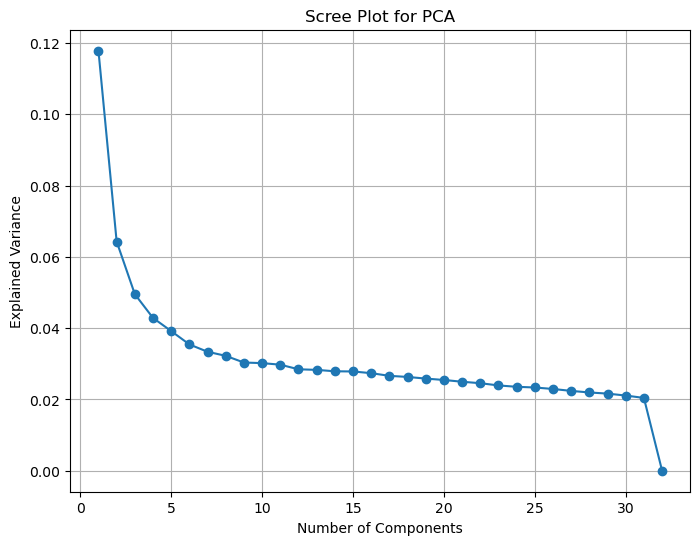

In [189]:
pca = PCA()
pca.fit(train_wo_labels)

explained_variances = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variances) + 1), explained_variances, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Scree Plot for PCA')
plt.grid(True)

# Scree plot
plt.show()

In [181]:
pca = PCA(n_components=5)

In [182]:
PCAComp = pca.fit_transform(train_wo_labels)

In [183]:
PCA_df = pd.DataFrame(data = PCAComp, columns = ['pc1', 'pc2','pc3','pc4','pc5'])
labels = pd.DataFrame(train_data['Label'])

PCA_df.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)

Final_df = pd.concat([PCA_df, labels], axis = 1)

PCA_var = pca.explained_variance_ratio_.sum()

In [184]:
print('The first 2 principal components explain',round(PCA_var*100,1),'% of the variance of the data')

The first 2 principal components explain 31.2 % of the variance of the data


In [185]:
Final_df

,pc1,pc2,pc3,pc4,pc5,Label
0,-569.342331,-532.785795,531.675106,152.827649,4.417804,1
1,926.055013,160.021939,-74.064395,-550.544349,180.641167,0
2,853.461988,-340.954640,-134.109361,106.137835,-133.296091,1
3,591.315543,-482.792944,-240.212835,691.008693,-278.820231,0
4,-678.779515,-567.452657,424.649432,35.121081,113.084899,1
5,-820.067608,362.481178,-623.179793,-181.082788,-345.986992,1
6,952.244288,-124.954525,-281.135281,-263.621575,205.073686,1
7,1009.526593,-228.016836,-280.643071,-192.641232,119.058493,0
8,514.419900,-581.252591,-100.633290,792.775819,-448.822791,1
9,1015.779413,2.209596,-98.483194,-528.219880,266.606316,1


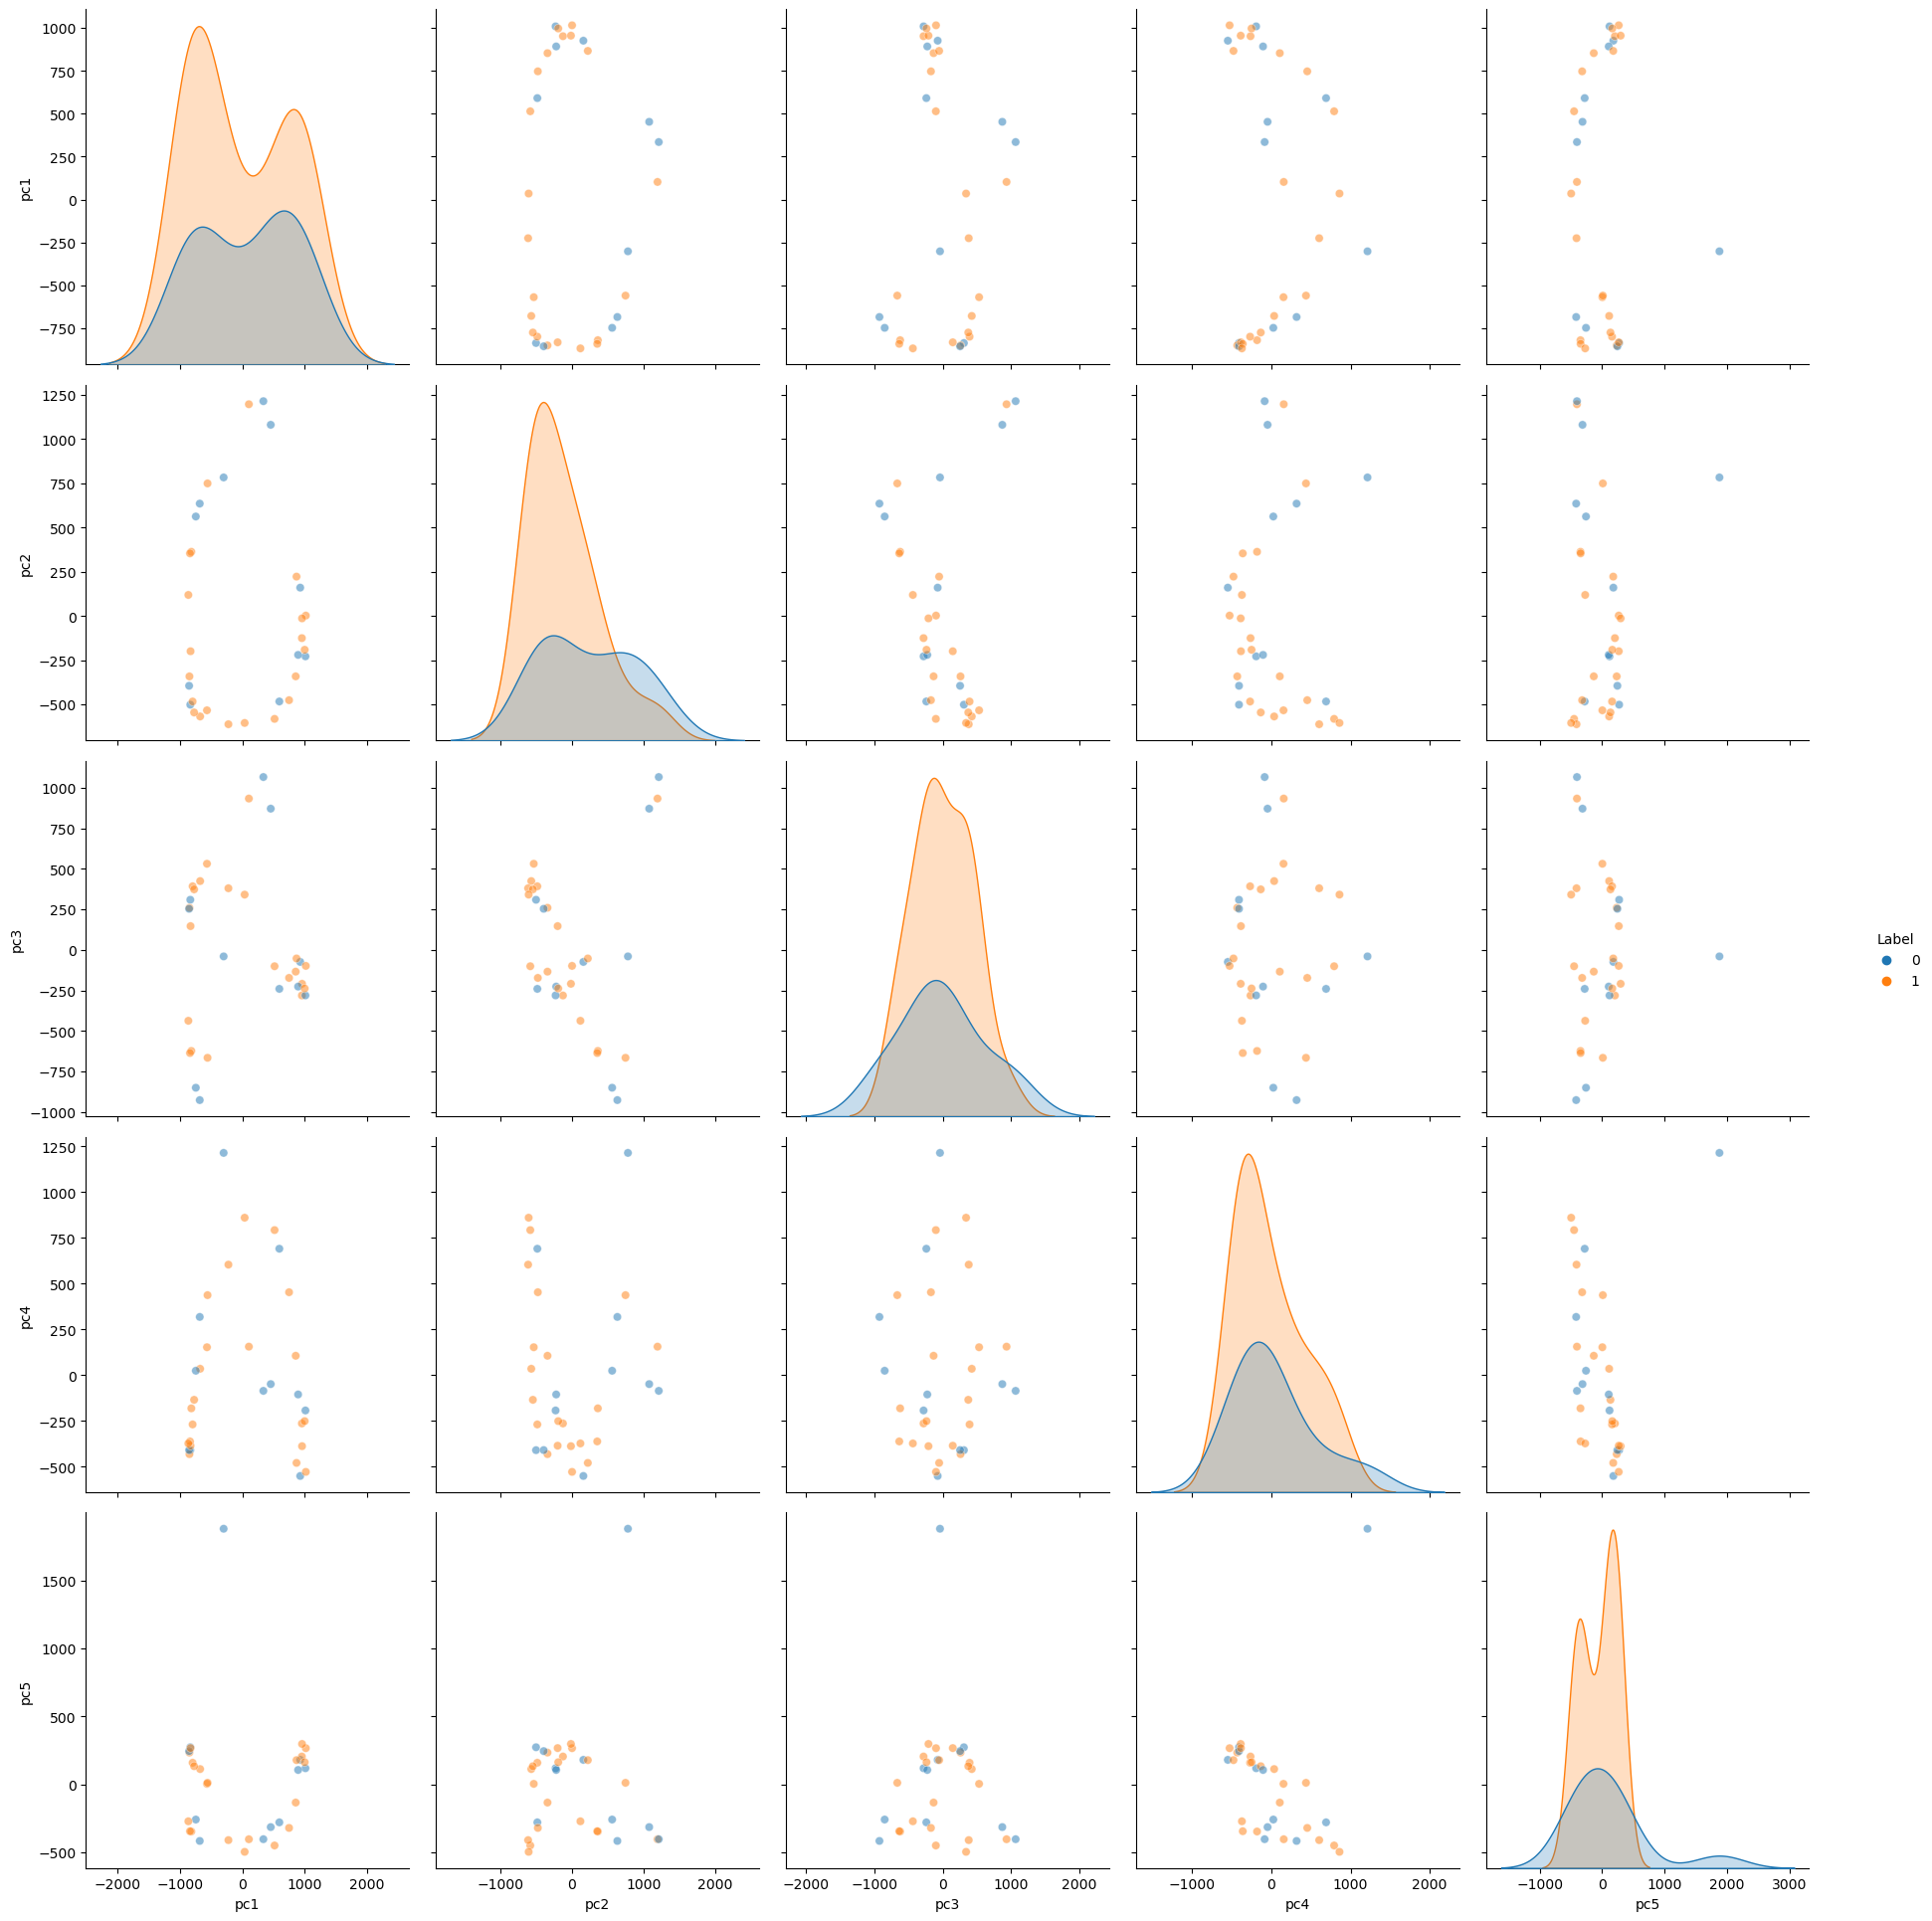

In [186]:
ax=sb.pairplot(Final_df,hue='Label',plot_kws={'alpha': 0.5},vars=['pc1','pc2','pc3','pc4','pc5'])
ax.fig.set_size_inches(20, 20)
plt.show()

In [187]:
svm_classifier = SVC(kernel='rbf', C= 0.92, random_state=42)

svm_classifier.fit(train_wo_labels, train_labels)

y_train_pred = svm_classifier.predict(train_wo_labels)

accuracy_train = accuracy_score(train_labels, y_train_pred)


print(f'Accuracy on the training data: {accuracy_train:.4f}')

Accuracy on the training data: 0.9688


In [188]:
y_test = np.asarray(test_labels)
y_test_pred = svm_classifier.predict(test_wo_labels)

accuracy_test = accuracy_score(y_test, y_test_pred)
print(f'Accuracy on the test data: {accuracy_test:.4f}')

Accuracy on the test data: 0.8750
